# 宿泊価格の予測

In [1]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error # モデル評価用(平均二乗誤差)
from sklearn.metrics import r2_score # モデル評価用(決定係数)
from sklearn.metrics import mean_absolute_error #モデル評価用

from sklearn import linear_model#欠損値予測用の線形回帰を生成する
from sklearn import preprocessing#単一ラベルエンコーディング用
from sklearn.preprocessing import OrdinalEncoder#複数ラベルエンコーディング用

from functools import partial
from glob import glob

import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import japanize_matplotlib
import optuna
import seaborn as sns
sns.set()

import lightgbm as lgb
import re

import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", 31) #dfの表示を30行までに変更

from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

In [2]:
# 必要なデータの読み込み
train = pd.read_csv("data/train.csv") # 学習用データ
test = pd.read_csv("data/test.csv")   # 評価用データ
sample_submit = pd.read_csv("data/sample_submit.csv")

# 合体前に目印の付与
train["check"]="train_data"
test["check"]="test_data"

# データの合体
df=pd.concat([train,test])

rm_cols = [] #削除予定のカテゴリ名一覧

# EDA①：データの確認

In [3]:
print(train.shape)
df.head()

(55583, 30)


,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,...,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y,check
0,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,...,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,138.0,train_data
1,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,...,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,42.0,train_data
2,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,...,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN,65.0,train_data
3,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,...,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,NaN,94133,166.0,train_data
4,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,...,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,165.0,train_data


In [4]:
# 詳細の確認(ここではdfではなくtrainのみ確認する)⇒重いので初回のみ
# train.profile_report()

In [5]:
# 欠損値・データ型の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 0 to 18527
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   accommodates            74111 non-null  int64  
 2   amenities               74111 non-null  object 
 3   bathrooms               73911 non-null  float64
 4   bed_type                74111 non-null  object 
 5   bedrooms                74020 non-null  float64
 6   beds                    73980 non-null  float64
 7   cancellation_policy     74111 non-null  object 
 8   city                    74111 non-null  object 
 9   cleaning_fee            74111 non-null  object 
 10  description             74111 non-null  object 
 11  first_review            58247 non-null  object 
 12  host_has_profile_pic    73923 non-null  object 
 13  host_identity_verified  73923 non-null  object 
 14  host_response_rate      55812 non-null

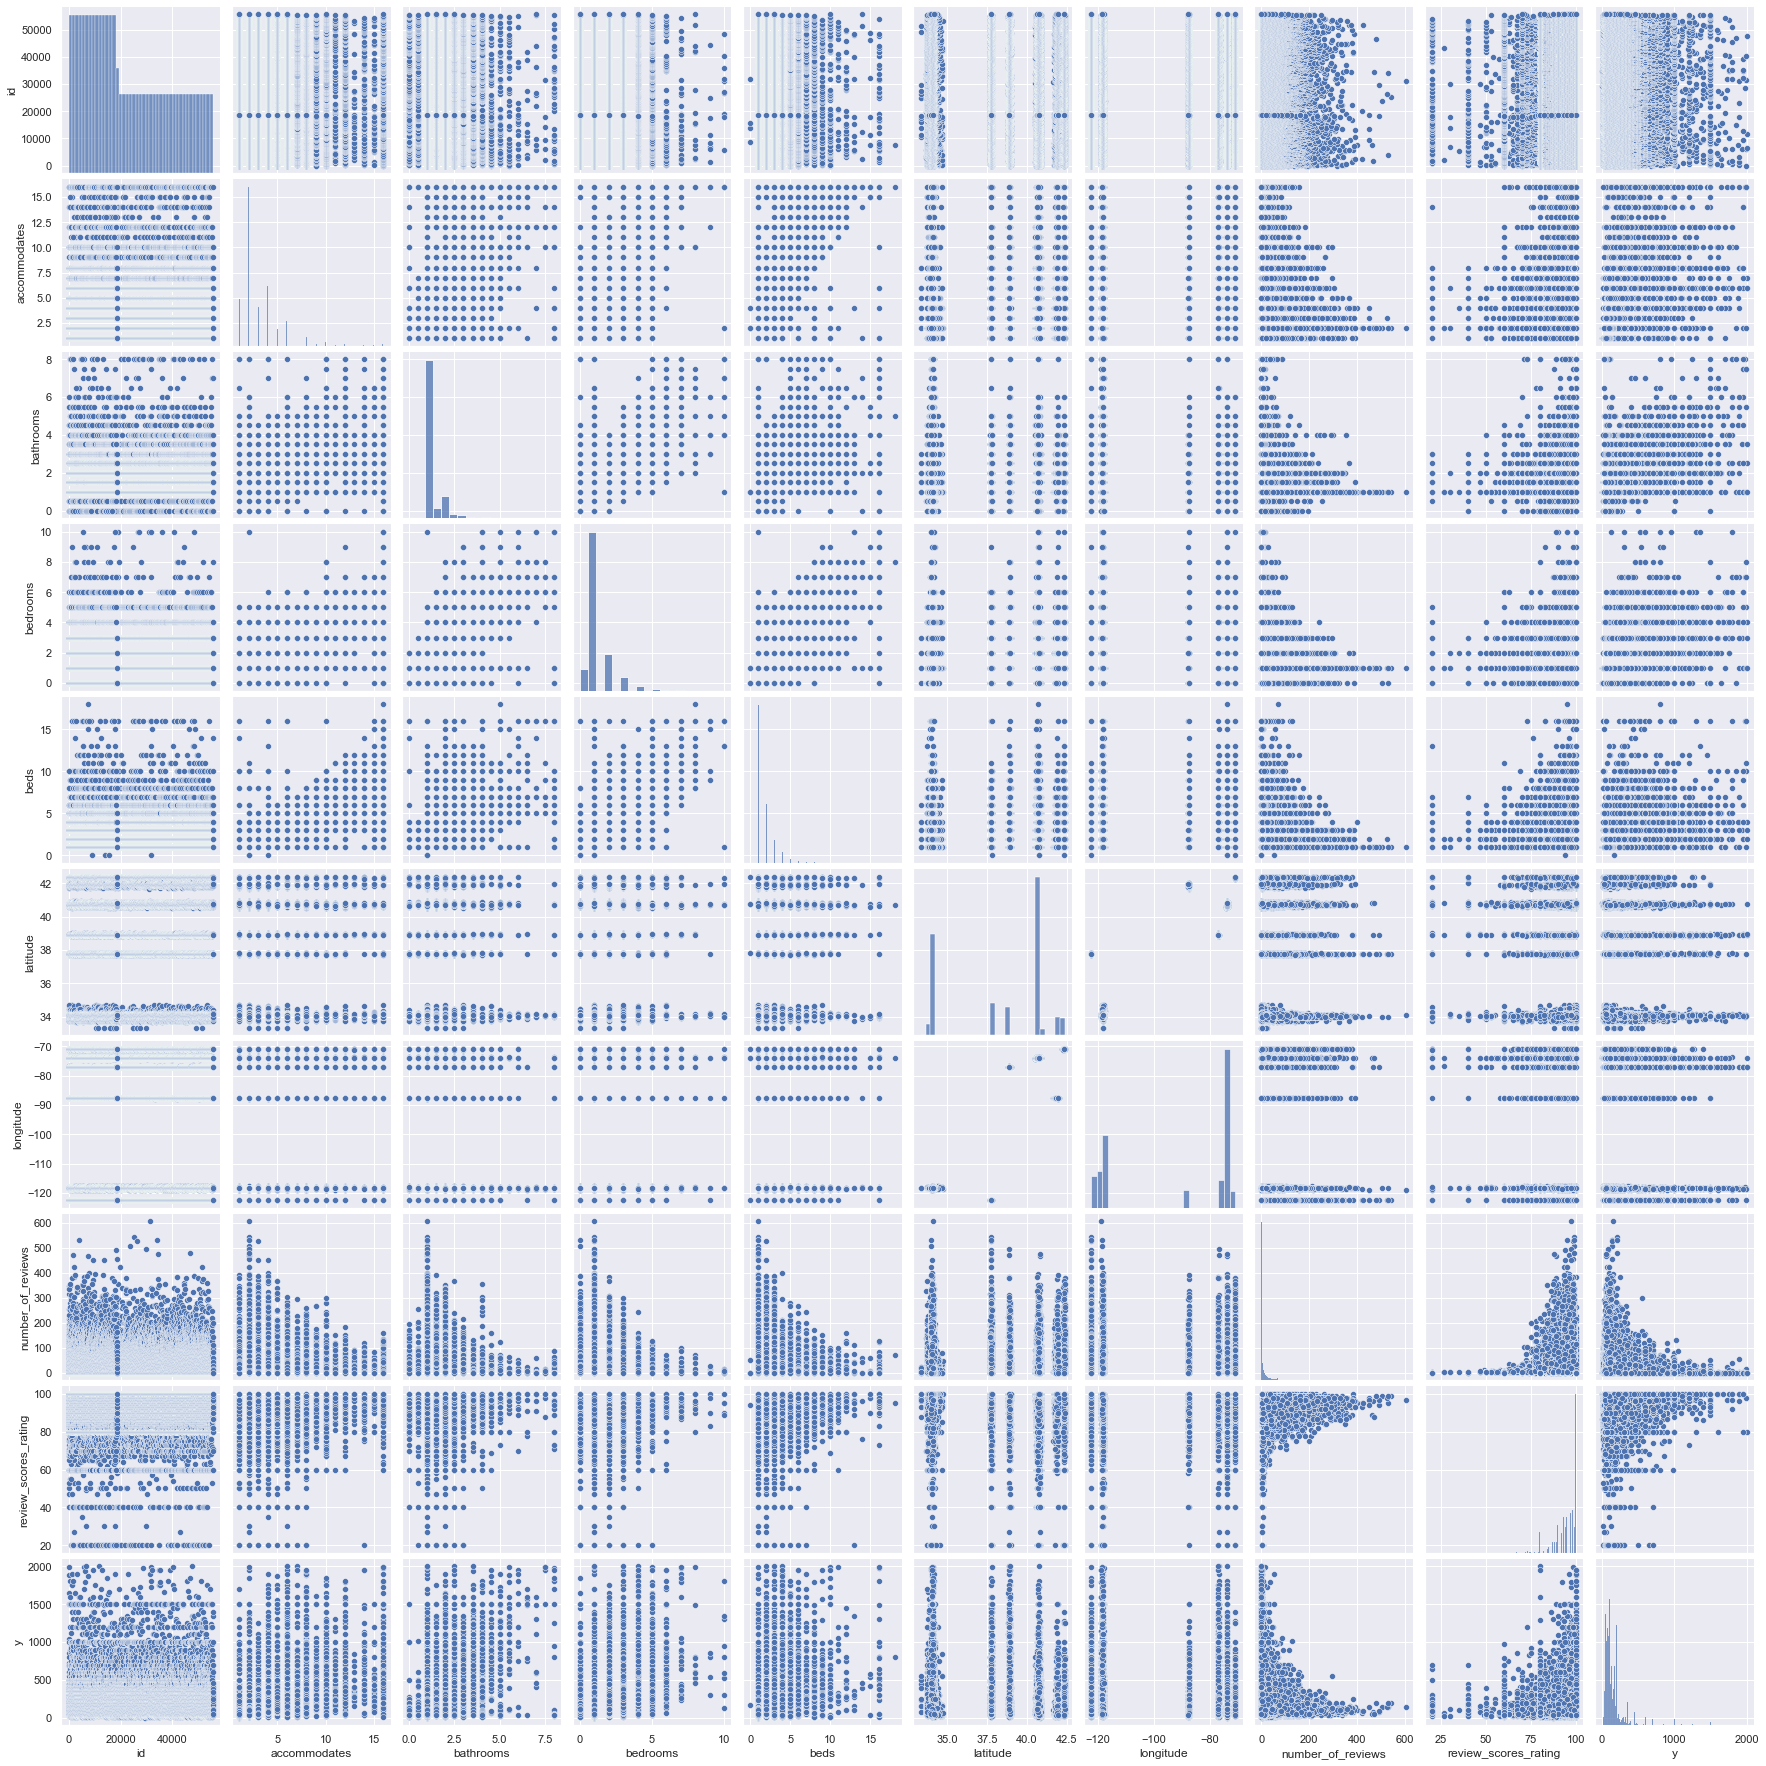

In [6]:
sns.pairplot(df)

In [7]:
df.corr()

,id,accommodates,bathrooms,bedrooms,beds,latitude,longitude,number_of_reviews,review_scores_rating,y
id,1.000000,0.003614,0.005566,0.002081,0.005599,-0.003067,-0.001253,0.004359,0.002774,-0.001129
accommodates,0.003614,1.000000,0.505632,0.709258,0.810801,-0.078309,-0.085160,0.041964,-0.017128,0.522330
bathrooms,0.005566,0.505632,1.000000,0.589935,0.525591,-0.137959,-0.135026,-0.041381,0.010537,0.456044
bedrooms,0.002081,0.709258,0.589935,1.000000,0.709416,-0.059162,-0.076113,-0.035149,0.011143,0.495830
beds,0.005599,0.810801,0.525591,0.709416,1.000000,-0.080294,-0.082150,0.031109,-0.027330,0.435603
latitude,-0.003067,-0.078309,-0.137959,-0.059162,-0.080294,1.000000,0.896065,-0.017642,-0.032858,-0.028940
longitude,-0.001253,-0.085160,-0.135026,-0.076113,-0.082150,0.896065,1.000000,-0.050009,-0.048801,-0.056236
number_of_reviews,0.004359,0.041964,-0.041381,-0.035149,0.031109,-0.017642,-0.050009,1.000000,0.011708,-0.068944
review_scores_rating,0.002774,-0.017128,0.010537,0.011143,-0.027330,-0.032858,-0.048801,0.011708,1.000000,0.065896
y,-0.001129,0.522330,0.456044,0.495830,0.435603,-0.028940,-0.056236,-0.068944,0.065896,1.000000


In [8]:
df.describe()

,id,accommodates,bathrooms,bedrooms,beds,latitude,longitude,number_of_reviews,review_scores_rating,y
count,74111.000000,74111.000000,73911.000000,74020.000000,73980.000000,74111.000000,74111.000000,74111.000000,57389.000000,55583.000000
mean,23159.062501,3.155146,1.235263,1.265793,1.710868,38.445958,-92.397525,20.900568,94.067365,160.163647
std,16266.832865,2.153589,0.582044,0.852143,1.254142,3.080167,21.705322,37.828641,7.836556,168.087140
min,0.000000,1.000000,0.000000,0.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,1.000000
25%,9263.500000,2.000000,1.000000,1.000000,1.000000,34.127908,-118.342374,1.000000,92.000000,74.000000
50%,18527.000000,2.000000,1.000000,1.000000,1.000000,40.662138,-76.996965,6.000000,96.000000,111.000000
75%,37054.500000,4.000000,1.000000,1.000000,2.000000,40.746096,-73.954660,23.000000,100.000000,185.000000
max,55582.000000,16.000000,8.000000,10.000000,18.000000,42.390437,-70.985047,605.000000,100.000000,1999.000000


# EDA②：object型の中身の確認

In [9]:
df["bed_type"].unique()

array(['Real Bed', 'Pull-out Sofa', 'Airbed', 'Futon', 'Couch'],
      dtype=object)

In [10]:
df["cancellation_policy"].unique()

array(['flexible', 'strict', 'moderate', 'super_strict_30',
       'super_strict_60'], dtype=object)

In [11]:
df["city"].unique()

array(['LA', 'DC', 'NYC', 'SF', 'Chicago', 'Boston'], dtype=object)

In [12]:
df["cleaning_fee"].unique()

array(['t', 'f'], dtype=object)

In [13]:
df["first_review"].unique()

array(['2016-07-27', '2016-09-12', '2016-06-15', ..., '2013-03-04',
       '2009-08-08', '2010-04-13'], dtype=object)

In [14]:
df["host_has_profile_pic"].unique()

array(['t', nan, 'f'], dtype=object)

In [15]:
df["host_identity_verified"].unique()

array(['f', 't', nan], dtype=object)

In [16]:
df["host_response_rate"].unique()

array([nan, '100%', '70%', '0%', '99%', '90%', '75%', '80%', '97%', '60%',
       '96%', '95%', '87%', '50%', '94%', '83%', '40%', '82%', '20%',
       '88%', '91%', '86%', '93%', '92%', '67%', '71%', '43%', '79%',
       '85%', '89%', '54%', '98%', '65%', '33%', '22%', '17%', '78%',
       '76%', '56%', '84%', '69%', '25%', '30%', '74%', '73%', '29%',
       '77%', '38%', '81%', '68%', '42%', '57%', '44%', '58%', '64%',
       '36%', '62%', '10%', '63%', '72%', '53%', '61%', '52%', '55%',
       '35%', '13%', '6%', '27%', '59%', '46%', '14%', '26%', '31%',
       '47%', '66%', '21%', '15%', '41%', '39%', '23%', '11%'],
      dtype=object)

In [17]:
df["host_since"].unique()

array(['2016-07-13', '2015-12-30', '2016-05-21', ..., '2009-08-05',
       '2008-09-17', '2009-08-14'], dtype=object)

In [18]:
df["instant_bookable"].unique()

array(['f', 't'], dtype=object)

In [19]:
df["last_review"].unique()

array(['2016-07-27', '2017-03-31', '2017-08-13', ..., '2014-05-06',
       '2015-02-22', '2014-05-31'], dtype=object)

In [20]:
df["property_type"].unique()

array(['Apartment', 'House', 'Townhouse', 'Loft', 'Cabin', 'Condominium',
       'Guest suite', 'Guesthouse', 'Other', 'Bungalow', 'Villa',
       'Bed & Breakfast', 'Dorm', 'Timeshare', 'Camper/RV', 'Cave',
       'Hostel', 'Earth House', 'In-law', 'Serviced apartment', 'Boat',
       'Tent', 'Castle', 'Boutique hotel', 'Vacation home', 'Hut',
       'Treehouse', 'Yurt', 'Chalet', 'Island', 'Tipi', 'Train',
       'Parking Space', 'Casa particular', 'Lighthouse'], dtype=object)

In [21]:
df["room_type"].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [22]:
df["zipcode"].unique()

array(['90804', '20018', nan, '94133', '10024', '11220', '11233', '90036',
       '11372', '10012', '10030', '90026', '10019', '60647', '10009.0',
       '11231.0', '11211.0', '90046', '91006', '20007', '11206.0',
       '11106', '90029', '60657', '90034', '94114', '60612', '10036',
       '10013.0', '90802', '90211', '90240', '90066', '20001', '94110',
       '11104', '90292', '90290', '90028', '90278', '10033', '91601',
       '11225', '94115.0', '20002', '11216.0', '11221', '60610', '11379',
       '90057', '20009', '11201.0', '94118', '11238', '11435', '02127',
       '10038', '10002.0', '91307', '11206', '90291', '90068', '10004',
       '11377', '90077', '10468', '11207.0', '02125', '11374', '11212.0',
       '90265', '91789', '60653', '94127', '10028', '11103', '90064',
       '91367', '10003', '60642', '10025', '90039', '91748', '10128',
       '90405', '60608', '10016', '10003.0', '91732', '11102', '11236',
       '02114', '02113', '11249.0', '91331', '20003', '02116', '91356'

# EDA③：単変量データの可視化

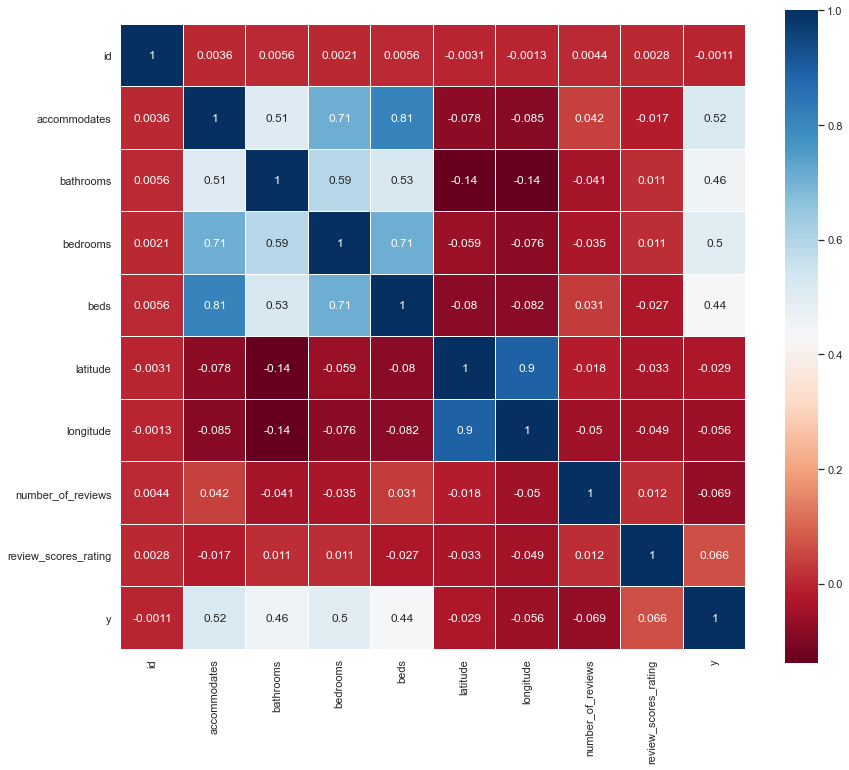

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 相関の確認
plt.figure(figsize=(14,12))
sns.heatmap(
    df.corr(),
    linewidths=0.1,
    vmax=1.0, 
    square=True,
    cmap=plt.cm.RdBu,
    linecolor='white',
    annot=True
)
plt.show()

<AxesSubplot:xlabel='y', ylabel='Count'>

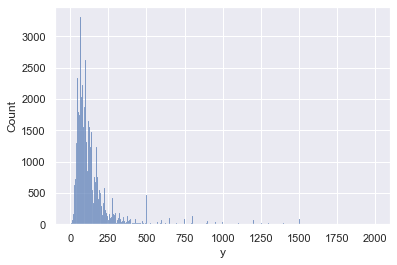

In [24]:
sns.histplot(df["y"])

# 前処理①：不要カラムの削除

In [25]:
rm_cols +=[
#     "amenities",　アメニティは残す。特に朝食は影響しそうなので。
    "description",
    "first_review",
    "host_has_profile_pic",
    "host_identity_verified",
    "bed_type",
    "host_since",
    "instant_bookable",
    "last_review",
    "latitude",
    "longitude",
    "name",
    "neighbourhood",
    "number_of_reviews",
    "review_scores_rating",
    "thumbnail_url",
    "host_response_rate",
    "cancellation_policy",
#     "zipcode"　郵便番号で大まかな地域は絞れるので特徴量になりそう
]

In [26]:
df.drop(rm_cols,axis=1,inplace=True)

In [27]:
df.columns

Index(['id', 'accommodates', 'amenities', 'bathrooms', 'bedrooms', 'beds',
       'city', 'cleaning_fee', 'property_type', 'room_type', 'zipcode', 'y',
       'check'],
      dtype='object')

# 前処理②：ダミー変数化・補完・新変数の生成

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 0 to 18527
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             74111 non-null  int64  
 1   accommodates   74111 non-null  int64  
 2   amenities      74111 non-null  object 
 3   bathrooms      73911 non-null  float64
 4   bedrooms       74020 non-null  float64
 5   beds           73980 non-null  float64
 6   city           74111 non-null  object 
 7   cleaning_fee   74111 non-null  object 
 8   property_type  74111 non-null  object 
 9   room_type      74111 non-null  object 
 10  zipcode        73145 non-null  object 
 11  y              55583 non-null  float64
 12  check          74111 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 7.9+ MB


In [29]:
# 欠損値の補完
df["bathrooms"].fillna(1,inplace=True)#バスルーム数「不明」は最頻値「1」で埋めます
df["bedrooms"].fillna(1,inplace=True)#ベッドルーム数「不明」は最頻値「1」で埋めます
df["beds"].fillna(1,inplace=True)#ベッド数「不明」は最頻値「1」で埋めます
df["zipcode"].fillna("no-data",inplace=True)#郵便番号「不明」は「"no-data"」で埋めます

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 0 to 18527
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             74111 non-null  int64  
 1   accommodates   74111 non-null  int64  
 2   amenities      74111 non-null  object 
 3   bathrooms      74111 non-null  float64
 4   bedrooms       74111 non-null  float64
 5   beds           74111 non-null  float64
 6   city           74111 non-null  object 
 7   cleaning_fee   74111 non-null  object 
 8   property_type  74111 non-null  object 
 9   room_type      74111 non-null  object 
 10  zipcode        74111 non-null  object 
 11  y              55583 non-null  float64
 12  check          74111 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 7.9+ MB


In [31]:
# ラベルエンコーディング(カテゴリを1.2.3.…と連番に変換する)
oe = preprocessing.OrdinalEncoder()
encoded = oe.fit_transform(df[["city","cleaning_fee","property_type","room_type","zipcode"]].values)#数値に変換したリスト
decoded = oe.inverse_transform(encoded)#元の文字列に戻したリスト。今回は使わないけどメモ

df[["city","cleaning_fee","property_type","room_type","zipcode"]]=encoded#代入
df.head()

,id,accommodates,amenities,bathrooms,bedrooms,beds,city,cleaning_fee,property_type,room_type,zipcode,y,check
0,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,1.0,4.0,3.0,1.0,0.0,1.0,579.0,138.0,train_data
1,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,1.0,1.0,2.0,1.0,17.0,1.0,348.0,42.0,train_data
2,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,1.0,1.0,4.0,1.0,0.0,1.0,769.0,65.0,train_data
3,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,1.0,1.0,5.0,1.0,0.0,1.0,762.0,166.0,train_data
4,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,1.0,1.0,4.0,1.0,0.0,0.0,79.0,165.0,train_data


In [32]:
# ダミー変数化　⇒　LabelEncodingしたのでOneHotEncodingはしない
# df_dummies=pd.get_dummies(df.drop(["check"],axis=1))
# df_dummies["check"]=df["check"]
# df_dummies.head()

In [33]:
# 新変数「街別平均宿泊料金」を作成 ⇒ 土地相場の把握が目的。リークしているので削除

# city_mean_df=df.groupby(["city"]).mean()[["bathrooms","bedrooms","y"]]
# city_mean_df.rename(columns={"bathrooms":"city_mean_bathrooms","bedrooms":"city_mean_bedrooms","y":"city_mean_y"},inplace=True)
# city_mean_df.head()

# df=pd.merge(df,city_mean_df,on="city")
# df

In [34]:
# 新変数ame〇〇の生成 ⇒ 削除したほうが精度高かったので削除

# df["TV"] = df["amenities"].str.contains("TV").astype(int)
# df["Internet"] = df["amenities"].str.contains("Internet").astype(int)
# df["Kitchen"] = df["amenities"].str.contains("Kitchen").astype(int)
# df["Air conditioning"] = df["amenities"].str.contains("Air conditioning").astype(int)
# df["Pool"] = df["amenities"].str.contains("Pool").astype(int)
# df["Family/kid friendly"] = df["amenities"].str.contains("Family/kid friendly").astype(int)
# df["Elevator"] = df["amenities"].str.contains("Elevator").astype(int)
# df["Gym"] = df["amenities"].str.contains("Gym").astype(int)
# df["Private living room"] = df["amenities"].str.contains("Private living room").astype(int)
# df["Doorman"] = df["amenities"].str.contains("Doorman").astype(int)
# df["Breakfast"] = df["amenities"].str.contains("Breakfast").astype(int)
# df["Essentials"] = df["amenities"].str.contains("Essentials").astype(int)
# df["Laptop friendly workspace"] = df["amenities"].str.contains("Laptop friendly workspace").astype(int)
# df["Shampoo"] = df["amenities"].str.contains("Shampoo").astype(int)
# df["Pets allowed"] = df["amenities"].str.contains("Pets allowed").astype(int)
# df["Carbon monoxide detector"] = df["amenities"].str.contains("Carbon monoxide detector").astype(int)

df.drop(["amenities"],axis=1,inplace=True)#amenities列は削除

In [35]:
#線形回帰で重要変数bathrooms、bedrooms、bedsを予測する ⇒ 先ほど1で補完しましたが精度上げのため重回帰を検討。リークしており削除。

# missing_value_df_X = df.dropna().drop(["y","bathrooms","bedrooms","beds","check"],axis=1)#欠損値予測用のXを生成

# missing_value_df_bathrooms_y = df.dropna()["bathrooms"]#欠損値予測用のyを生成
# missing_value_df_bedrooms_y = df.dropna()["bedrooms"]
# missing_value_df_beds_y = df.dropna()["beds"]

# lr = linear_model.LinearRegression()

# lr.fit(missing_value_df_X,missing_value_df_bathrooms_y)
# pred_missing_value_df_bathrooms_y=lr.predict(missing_value_df_X)

# lr.fit(missing_value_df_X,missing_value_df_bedrooms_y)
# pred_missing_value_df_bedsrooms_y=lr.predict(missing_value_df_X)

# lr.fit(missing_value_df_X,missing_value_df_beds_y)
# pred_missing_value_df_beds_y=lr.predict(missing_value_df_X)

# print(pred_missing_value_df_bathrooms_y,
#       pred_missing_value_df_bedsrooms_y,
#       pred_missing_value_df_beds_y)

In [36]:
# missing_value_df_X["pred_missing_value_df_bathrooms_y"]=pred_missing_value_df_bathrooms_y
# missing_value_df_X["pred_missing_value_df_bedsrooms_y"]=pred_missing_value_df_bedsrooms_y
# missing_value_df_X["pred_missing_value_df_beds_y"]=pred_missing_value_df_beds_y

# missing_value_df=missing_value_df_X[["id","pred_missing_value_df_bathrooms_y","pred_missing_value_df_bedsrooms_y","pred_missing_value_df_beds_y"]]

# df=pd.merge(df,missing_value_df,on="id",how="left")

# 前処理③：外れ値の処理
本来はデータを確認するべきだが時間ないため割愛

# dfの整理

In [37]:
train_df = df[df["check"]=="train_data"].drop(["check"],axis=1) 
test_df = df[df["check"]=="test_data"] .drop(["check"],axis=1)

print(train_df.shape,test_df.shape)

(55583, 11) (18528, 11)


In [38]:
train_y=train_df["y"]
train_X=train_df.drop(["y"],axis=1)
test_y=test_df["y"]
test_X=test_df.drop(["y"],axis=1)

In [39]:
train_X, val_X, train_y, val_y = train_test_split(train_X,train_y,test_size=0.3,random_state=0)

print(train_X.shape, val_X.shape, train_y.shape, val_y.shape)

(38908, 10) (16675, 10) (38908,) (16675,)


# 学習

In [40]:
SEED = 0

params = {
    'objective': 'regression',
    'metric': 'mse',#mae or mse が良い。GridSearchできるし。
    'num_leaves': 45,#分岐の個数31がデフォ。大きくすると適合率は上がるが過学習が進む
    'max_depth': -1,#木の深さ-1がデフォ。
    'max_bin':255,#一つの葉に入るデータ数255がデフォ。過学習を防ぐ
    "feature_fraction": 0.8,#学習の高速化と過学習の抑制に使用
    'subsample_freq': 1,#バギングする頻度。よく分からない。
    "bagging_fraction": 0.95,#訓練の計算速度向上らしいがよく分からない。
    'min_data_in_leaf': 2,#よく分からない。
    'learning_rate': 0.05,#学習率0.1がデフォ。
    "boosting": "gbdt",#基本的に変更しない
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,#乱数シード。必ず固定すること
    "num_boost_round": 50000,#木の数(num_iterationsでも同義).earty_stoppingを使うので実質無限に相当する値を指定
    "early_stopping_rounds": 100
}

train_data = lgb.Dataset(train_X, train_y)
val_data = lgb.Dataset(val_X, val_y,reference=train_data)

model = lgb.train(
    params,
    train_data, 
    valid_names = ['train', 'val'],
    valid_sets =[train_data, val_data], 
    verbose_eval = 10,
)

Training until validation scores don't improve for 100 rounds
[10]	train's l2: 19839.8	val's l2: 20682
[20]	train's l2: 16322.3	val's l2: 17275.3
[30]	train's l2: 14536.7	val's l2: 15687.2
[40]	train's l2: 13566.5	val's l2: 14905.5
[50]	train's l2: 12925.5	val's l2: 14449.6
[60]	train's l2: 12474.7	val's l2: 14227.5
[70]	train's l2: 12122.4	val's l2: 14047.7
[80]	train's l2: 11834.9	val's l2: 13943.6
[90]	train's l2: 11587	val's l2: 13854.9
[100]	train's l2: 11387.8	val's l2: 13801.1
[110]	train's l2: 11215.3	val's l2: 13747.5
[120]	train's l2: 11063.9	val's l2: 13724.3
[130]	train's l2: 10916.6	val's l2: 13711.8
[140]	train's l2: 10790.6	val's l2: 13688.8
[150]	train's l2: 10667.9	val's l2: 13680.5
[160]	train's l2: 10555.9	val's l2: 13687.5
[170]	train's l2: 10455	val's l2: 13683.8
[180]	train's l2: 10348.4	val's l2: 13673.3
[190]	train's l2: 10260.8	val's l2: 13676.2
[200]	train's l2: 10172.4	val's l2: 13677.3
[210]	train's l2: 10086.8	val's l2: 13685.8
[220]	train's l2: 10014.2	val

In [41]:
val_pred = model.predict(val_X, num_iteration=model.best_iteration)
score = np.sqrt(mean_squared_error(val_y, val_pred))

pred_df = pd.DataFrame(sorted(zip(val_X.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train_X.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')

score: 116.9181


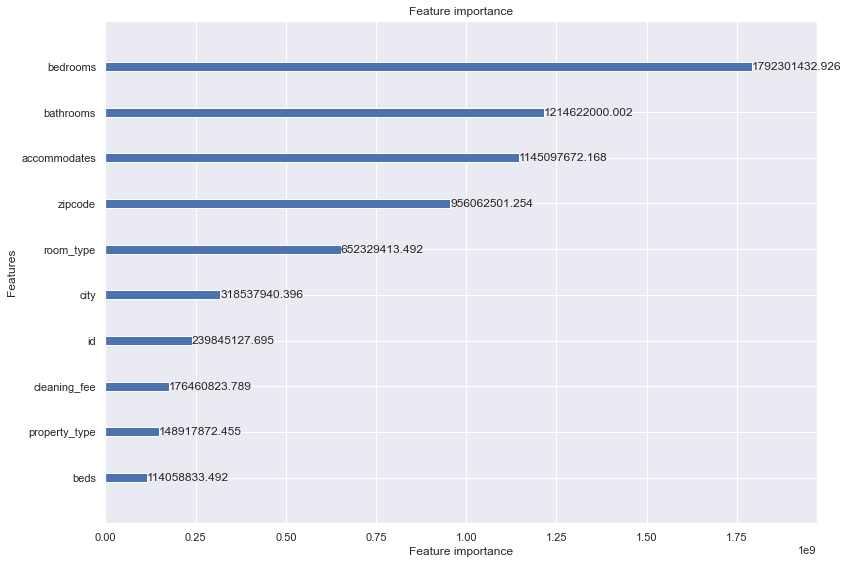

In [42]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()
plt.close()

In [43]:
# lightGBMによる予測値の算出
y_pred_byLG = model.predict(test_X, num_iteration=model.best_iteration)

In [44]:
# ランダムフォレストの実装
from sklearn.ensemble import RandomForestRegressor

# 学習
forest = RandomForestRegressor(criterion="mse",random_state=42,n_estimators=500)#n_estimatorsは決定木の数。デフォルトは10だが少なすぎ。
forest.fit(train_X,train_y)

# 予測値算出
y_pred_byRf = forest.predict(test_X)

In [45]:
# アンサンブルする
test_df["TARGET"] = (y_pred_byLG + y_pred_byRf)/2
sub_df = test_df[['id', "TARGET"]]
sub_df.to_csv('data/test_submission.csv', header=False,index=False)